In [45]:
import numpy as np

import matplotlib.pyplot as plt

# ODE Setup

ODE system, numerics and plots

Putting the Sun as the origin of the coordinates then we have a system of equations:

$$ \dot{r} = \vec{v} $$
$$ \dot{v} = - \frac{GM \vec{r}}{r^3}$$

with

$\vec{r} = (x, y)$ and $\vec{v} = (v_{x}, v_{y})$

Euler's Method employs the first-order difference approximation:

$$ \frac{ \vec{r}^{n+1} - \vec{r}^{n}}{\tau} = \vec{v}^{n} + \mathcal{O}(\tau) $$
$$ \frac{\vec{v}^{n+1} - \vec{v}^{n}}{\tau} = \vec{a}(\vec{r}^{n}, \vec{v}^{n}) + \mathcal{O}(\tau) $$

The new state in terms of the old is expressed as

$$ \vec{r}^{n+1} = \vec{r}^{n} + \tau \vec{v}^{n} + \mathcal{O}(\tau ^2)$$

$$ \vec{v}^{n+1} = \vec{v}^{n} + \tau \vec{a}(\vec{r}^{n}, \vec{v}^{n}) + \mathcal{O}(\tau ^2) $$


To evelove to some time $\bf{T}$ we must take a large number of time steps, $\bf{N}$, $\bf{N} = \frac{\bf{T}}{\tau}$ so we will have error that is $\mathcal{O}(\tau)$ so the method is first-order accurate. 

In [46]:
G = 4*np.pi**2

M_sun = 1.0

First we will setup vector arrays for the vector inputs and their derivatives: $ \bf{Y} = \left( \begin{array} \\ x \\ y \\ v_{x} \\ v_{y} \end{array} \right) $

In [47]:
def rhs(t, Y):
  x, y, vx, vy = Y

  xdot = vx
  ydot = vy

  r = np.sqrt(x*x + y*y)

  vxdot = -G * M_sun * x / r**3
  vydot = -G * M_sun * y / r**3

  return np.array([xdot, ydot, vxdot, vydot])

We want to take data points while the solution is being done rather than just taking the final data point. We will store solutions along each step of the solver until the end.

In [48]:
class OrbitHistory:
  """store the time history of the orbit solution"""

  def __init__(self):
    self.t = []
    self.x = []
    self.y = []
    self.vx = []
    self.vy = []

  def store_current_solution(self, t, Y):
    self.t.append(t)
    self.x.append(Y[0])
    self.y.append(Y[1])
    self.vx.append(Y[2])
    self.vy.append(Y[3])

Next we will construct initial conditions and an integrator for equal time steps size $\tau$ until time $T$

In [49]:
def euler_orbit(Y0, tau, T):

  # return an orbit history object
  o = OrbitHistory()

  # storage of the new solution
  Y = Y0.copy()

  # initialize time
  t = 0

  # store the initial conditions
  o.store_current_solution(t, Y0)

  # main timestep loop
  while t < T:

    # make sure that the last step does not pass time T
    if t + tau > T:
      tau = T - t

    # get the RHS of the ODE
    Ydot = rhs(t, Y)

    # do the Euler update
    Y += tau * Ydot
    t += tau

    # store the state
    o.store_current_solution(t, Y)

  return o

Starting on the $+y$ axis and giving the Earth a counter-clockwise rotation

In [50]:
x0 = 0
y0 = 1
vx0 = -np.sqrt(G*M_sun/y0)
vy0 = 0

Y0 = np.array([x0, y0, vx0, vy0])

Now to integrate for one period. $T = 1$ would represent one year in our units. Let's do a timestep of one month

In [51]:
T = 1
tau = T/12.0

orbit = euler_orbit(Y0, tau, 1)

Plot the solution

Text(0, 0.5, 'y [AU]')

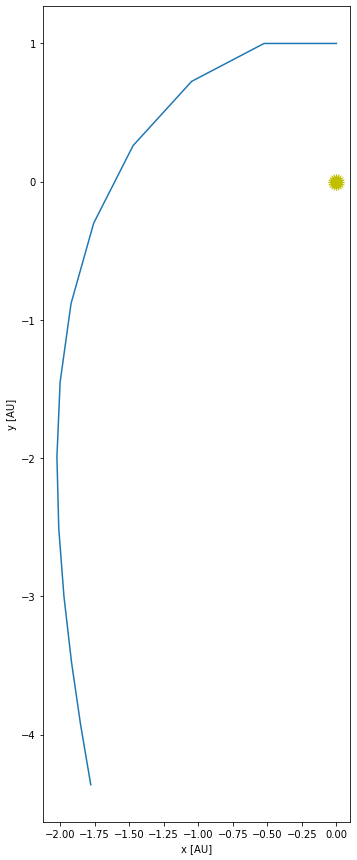

In [52]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20,1), color="y", s=250)

# draw the orbit
ax.plot(orbit.x, orbit.y)

ax.set_aspect("equal")
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

We need to fix this solution. We would assume a circular orbit and after 1 year to be back where we started. Adjusting the timestep size may help the solution to converge

Text(0, 0.5, 'y [AU]')

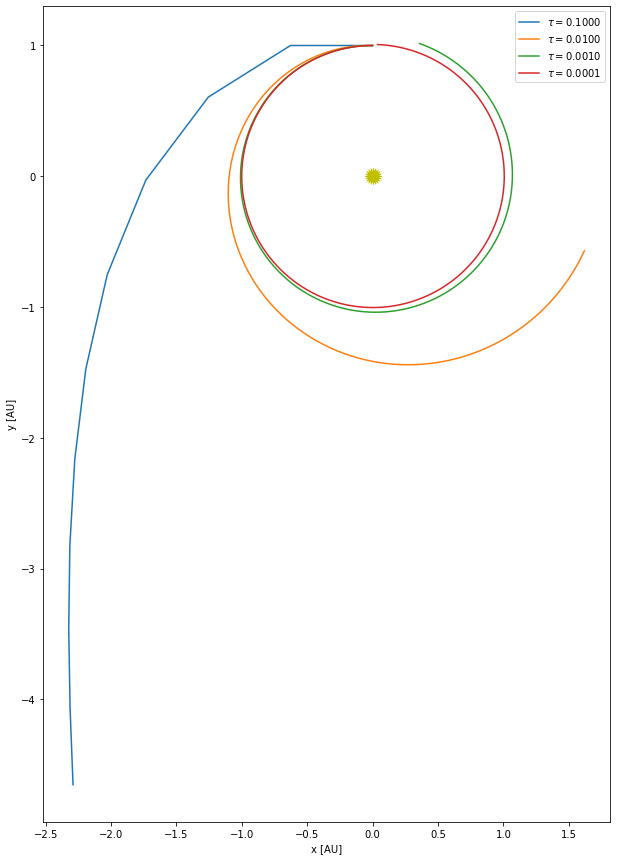

In [53]:
# figsize adjusts size of plot for viewing
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

# draw the Sun
ax.scatter([0], [0], marker=(20, 1), color="y", s=250)

taus = [0.1, 0.01, 0.001, 0.0001]

for tau in taus:
  orbit = euler_orbit(Y0, tau, T)

  ax.plot(orbit.x, orbit.y, label=rf"$\tau = {tau:6.4f}$")

ax.set_aspect("equal")
ax.legend()
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")

# Convergence of Numerical Solution

A few ways to measure how well the integrator is doing

1.  Compare the current distance to the Sun to the original distance to the Sun

2. Compute the distance from the current $(x,y)$ position to the starting position 

3. Compute the total energy at the end of the integration and compare to the initial total energy


There are many more ways that we could measure our numerical error but these will suffice. Depending on our goal on way to measure error might be more useful than others. We will choose one.


In [56]:
def error(history):

  # define the error to be the distance from (0,0) at the end compared to the start
  R_orig = np.sqrt(history.x[0]**2 + history.y[0]**2)
  R_new = np.sqrt(history.x[-1]**2 + history.y[-1]**2)

  e = np.abs(R_new - R_orig)

  return e

If we integrate a bunch or orbits while reducing the timestep by 2, since the Euler method is first order, the error should also decrease by a factor of 2.

In [57]:
taus = [0.1, 0.05, 0.025, 0.0125, 0.00625]

for tau in taus:
  orbit = euler_orbit(Y0, tau, T)
  print(error(orbit))

4.186923100574993
2.63132561836189
1.579518716431993
0.8788126438377246
0.45891625361582156


The decrease in error is about 2